In [18]:
import numpy as np 
import pandas as pd
import timm 
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import time
import os
import torchvision.transforms as T
from torch.amp import autocast
from matplotlib import pyplot as plt
from kornia import tensor_to_image
from kornia.contrib import extract_tensor_patches, compute_padding
from pprint import pprint
import re

In [19]:
def extract_binomial(name):
    """
    提取双名法：
    - 杂交属（× Genus species）去掉前缀 ×
    - 杂交种（Genus × species）保留 ×
    """
    # 1. 杂交属（× Genus species）
    hybrid_genus_pattern = r'^\s*×\s*([A-Z][a-z-]+)\s+([a-z-]+)'
    m = re.match(hybrid_genus_pattern, name)
    if m:
        genus, species = m.groups()
        genus = genus.replace('×', '').strip()
        return f"{genus} {species}"

    # 2. 普通属 + 种，或自然杂交种（Genus × species）
    normal_pattern = r'^([A-Z][a-z-]+)\s+(×?\s?[a-z-]+)'
    m = re.match(normal_pattern, name)
    if m:
        genus, species = m.groups()
        species = species.replace('×', '').strip()
        return f"{genus} {species}"

    return None

In [3]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

class PatchDataset(Dataset):
    def __init__(self, patches, transform=None):
        self.patches = patches.squeeze(0)
        self.transform = transform

    def __len__(self):
        return self.patches.size(0)

    def __getitem__(self, idx):
        patch = self.patches[idx]
        
        if self.transform:
            patch = self.transform(patch)
        return patch


class TestDataset(Dataset):
    def __init__(self, image_folder, patch_size=518, stride=259, transform=None, use_pad=False):
        self.image_folder = image_folder
        self.image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
        self.transform = transform
        self.use_pad = use_pad
        self.patch_size = patch_size
        self.stride = stride
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image).unsqueeze(0)
        
        h, w = image.shape[-2:]
        
        if self.use_pad:
            pad = compute_padding(original_size=(h, w), window_size=self.patch_size, stride=self.stride)
            patches = extract_tensor_patches(image, self.patch_size, self.stride, padding=pad)
        else:
            patches = extract_tensor_patches(image, self.patch_size, self.stride)

        return patches, image_path

In [9]:
df_species_ids = pd.read_csv('./species_ids.csv')

df_metadata = pd.read_csv('./PlantCLEF2024_single_plant_training_metadata.csv', sep=';', dtype={'partner': str})
class_map = df_species_ids['species_id'].to_dict() # dictionary to map the species model Id with the species Id
id_to_species = df_metadata[['species_id', 'species']].drop_duplicates().set_index('species_id')
id_to_species_dict = id_to_species['species'].to_dict()

df_metadata.head()

image_name organ  species_id      obs_id  \
0  59feabe1c98f06e7f819f73c8246bd8f1a89556b.jpg  leaf     1396710  1008726402   
1  dc273995a89827437d447f29a52ccac86f65476e.jpg  leaf     1396710  1008724195   
2  416235e7023a4bd1513edf036b6097efc693a304.jpg  leaf     1396710  1008721908   
3  cbd18fade82c46a5c725f1f3d982174895158afc.jpg  leaf     1396710  1008699177   
4  f82c8c6d570287ebed8407cefcfcb2a51eaaf56e.jpg  leaf     1396710  1008683100   

    license partner          author  altitude   latitude  longitude  \
0  cc-by-sa     NaN   Gulyás Bálint  205.9261  47.592160  19.362895   
1  cc-by-sa     NaN    vadim sigaud  323.7520  47.906703   7.201746   
2  cc-by-sa     NaN     fil escande  101.3160  48.826774   2.352774   
3  cc-by-sa     NaN  Desiree Verver    5.1070  52.190427   6.009677   
4  cc-by-sa     NaN      branebrane  165.3390  45.794739  15.965862   

   gbif_species_id           species  genus    family   dataset publisher  \
0        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
1        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
2        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
3        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   
4        5284517.0  Taxus baccata L.  Taxus  Taxaceae  plantnet  plantnet   

                                          references  \
0  https://identify.plantnet.org/fr/k-southwester...   
1  https://identify.plantnet.org/fr/k-southwester...   
2  https://identify.plantnet.org/fr/k-southwester...   
3  https://identify.plantnet.org/fr/k-southwester...   
4  https://identify.plantnet.org/fr/k-southwester...   

                                                 url learn_tag  \
0  https://bs.plantnet.org/image/o/59feabe1c98f06...     train   
1  https://bs.plantnet.org/image/o/dc273995a89827...     train   
2  https://bs.plantnet.org/image/o/416235e7023a4b...     train   
3  https://bs.plantnet.org/image/o/cbd18fade82c46...     train   
4  https://bs.plantnet.org/image/o/f82c8c6d570287...     train   

                                    image_backup_url  
0  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
1  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
2  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
3  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...  
4  https://lab.plantnet.org/LifeCLEF/PlantCLEF202...

In [5]:
device = torch.device('cuda')
model = timm.create_model('vit_base_patch14_reg4_dinov2.lvd142m',
                          pretrained=False,
                          num_classes=len(df_species_ids),
                          checkpoint_path='./model_best.pth.tar')
model = model.to(device)
model = model.eval()

In [6]:
data_config = timm.data.resolve_model_data_config(model)
model_input_size, model_mean, model_std = data_config['input_size'][1], data_config['mean'], data_config['std']

In [30]:
batch_size = 64
min_score = 0.1
top_k_tile = 5
patch_size = model_input_size
stride = int(model_input_size / 2)
use_pad = True
image_to_tensor = T.ToTensor()

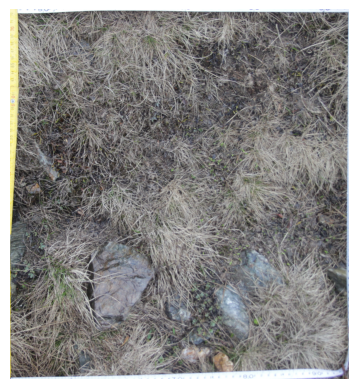


image_path: ./test_imgs/CBN-Pla-F6-20180724.jpg
plant ids:
[1741808, 1361281, 1743923, 1394597]
latin names:

['Anemonoides baldensis',
 'Festuca ovina',
 'Narcissus cuneiflorus',
 'Pinguicula corsica']


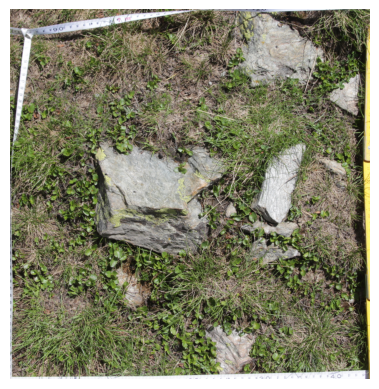


image_path: ./test_imgs/CBN-Pla-C5-20190723.jpg
plant ids:
[1361281, 1742052, 1396869, 1394311, 1390793, 1697365]
latin names:

['Festuca ovina',
 'Leontopodium nivale',
 'Trifolium thalii',
 'Oreochloa disticha',
 'Carex curvula',
 'Viola montcaunica']


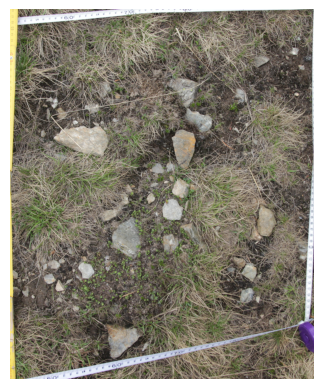


image_path: ./test_imgs/CBN-Pla-F2-20180724.jpg
plant ids:
[1361281, 1651363, 1395942, 1722440, 1392565]
latin names:

['Festuca ovina',
 'Festuca quadriflora',
 'Saxifraga androsacea',
 'Sesleria albicans',
 'Gentiana terglouensis']


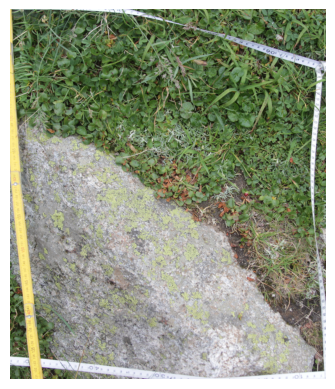


image_path: ./test_imgs/CBN-PdlC-A2-20200812.jpg
plant ids:
[1742053, 1395974, 1392558, 1396408, 1412857]
latin names:

['Omalotheca hoppeana',
 'Saxifraga florulenta',
 'Gentiana pumila',
 'Armeria multiceps',
 'Omalotheca supina']


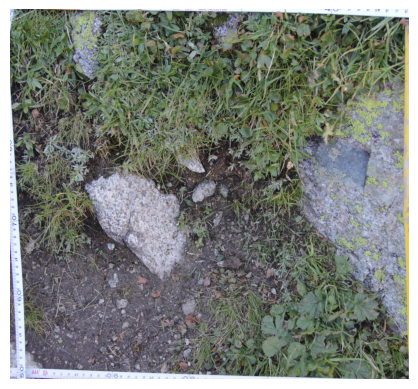


image_path: ./test_imgs/CBN-PdlC-A1-20180815.jpg
plant ids:
[1392608, 1412857, 1357575]
latin names:

['Geum montanum', 'Omalotheca supina', 'Filago carpetana']


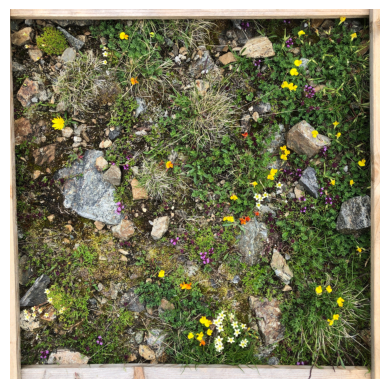


image_path: ./test_imgs/CBN-Pyr-03-20230706.jpg
plant ids:
[1741624, 1395973]
latin names:

['Lotus alpinus', 'Saxifraga exarata']


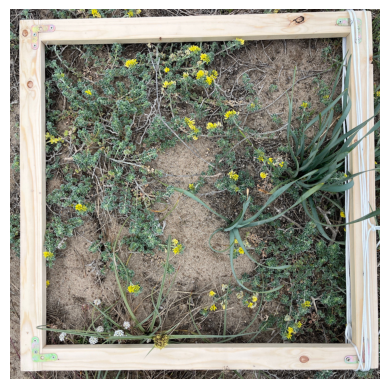


image_path: ./test_imgs/GUARDEN-AMB-CF04-1-10-20240325.jpg
plant ids:
[1359344]
latin names:

['Medicago marina']


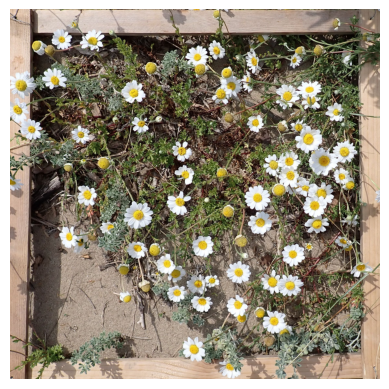


image_path: ./test_imgs/GUARDEN-CBNMed-30-4-16-3-20240428.jpg
plant ids:
[1357227]
latin names:

['Anthemis maritima']


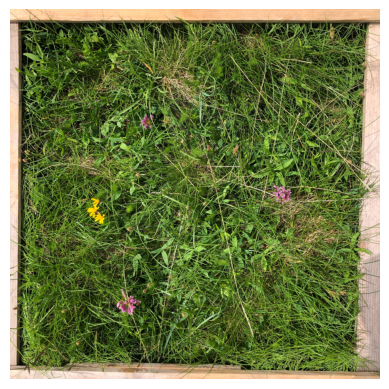


image_path: ./test_imgs/CBN-Pyr-01-20230706.jpg
plant ids:
[1396843, 1361284]
latin names:

['Trifolium alpinum', 'Festuca rubra']


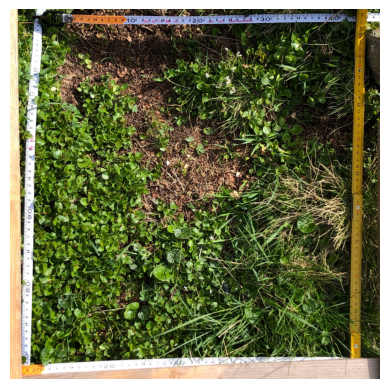


image_path: ./test_imgs/CBN-can-C1-20230705.jpg
plant ids:
[1393200, 1395807]
latin names:

['Homogyne alpina', 'Salix herbacea']


In [31]:
dataset = TestDataset(image_folder='./test_imgs',
                      patch_size=patch_size,
                      stride=stride,
                      use_pad=True,
                      transform=image_to_tensor)
dataloader = DataLoader(dataset, batch_size=1, num_workers=4, pin_memory=True)

image_predictions = {}
pred_result = {}

# Initialize batch time tracking
batch_time = AverageMeter()
end = time.time()

with torch.no_grad():
    for batch_idx, (patches, image_path) in enumerate(dataloader):
        image_results = {}
        quadrat_id = os.path.splitext(os.path.basename(image_path[0]))[0]
        transform_patch = T.Normalize(mean=model_mean, std=model_std)
        patch_dataset = PatchDataset(patches[0], transform=transform_patch)
        patch_loader = DataLoader(patch_dataset, batch_size=batch_size, shuffle=False)

        sp_id_list = []
        sp_id_probs = []
        for batch_patches in patch_loader:
            batch_patches = batch_patches.to(device)
            
            with autocast('cuda'):
                outputs = model(batch_patches)  # Perform inference on the batch
                probabilities = torch.nn.functional.softmax(outputs, dim=1)
                top_probs, top_indices = torch.topk(probabilities, 10)
                mask = top_probs > min_score
                filtered_top_probs = top_probs[mask]
                k = min(top_k_tile, filtered_top_probs.numel())
                _, indices = torch.topk(top_probs.view(-1), k)
                plant_sp_ids = list(top_indices.view(-1)[indices].cpu().numpy())
                sp_prob = list(top_probs.view(-1)[indices].cpu().numpy())
                sp_ids = [class_map[int(idx)] for idx in plant_sp_ids]
                sp_id_prob = [v for v in zip(sp_ids, sp_prob)]
                sp_id_probs.extend(sp_id_prob)
                sp_id_list.extend(sp_ids)
                
                
        sp_id_list = list(set(sp_id_list))
        # store the prediction
        image_predictions[quadrat_id] = sp_id_list
        latin_names = [extract_binomial(id_to_species_dict[id1]) for id1 in sp_id_list]
        pred_result[quadrat_id] = sp_id_probs
        batch_time.update(time.time() - end)
        end = time.time()
        plt.figure()
        plt.imshow(Image.open(image_path[0]))
        plt.axis('off')
        plt.show()
        print(f"\nimage_path: {image_path[0]}\nplant ids:")
        pprint(sp_id_list)
        print("latin names:\n")
        pprint(latin_names)
        